## Model training

In [ ]:
# Cell 1: Setup & Imports (e10)

import pandas as pd
import numpy as np
from pathlib import Path
import gc

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

BASE_DIR = Path.home() / "work"
FEATURES_PATH = BASE_DIR / "features_sampled_e10_2023_2024.parquet"

TRAIN_END = pd.Timestamp("2024-06-30")
VALID_END = pd.Timestamp("2024-09-30")

print("Setup complete.")

Setup complete.


In [ ]:
# Cell 2: Data Loading, Optimisation & Time Split

# 1. Load feature parquet (with intra-day lags)
df = pd.read_parquet(FEATURES_PATH)

keep_cols = [
    "station_uuid",
    "date",
    "time_cell",
    "price",
    "price_lag_1d",
    "price_lag_2d",
    "price_lag_3d",
    "price_lag_7d",
    "price_lag_1cell",
    "price_lag_2cell",
    "price_lag_3cell",
    "price_lag_4cell",
]
df = df[keep_cols]

# Types / memory
df["date"] = pd.to_datetime(df["date"])

float_cols = [
    c
    for c in df.columns
    if c.startswith("price") or c == "time_cell"
]
for c in float_cols:
    df[c] = df[c].astype("float32")

# Deterministic ordering: by station, then date, then time_cell
df = df.sort_values(["station_uuid", "date", "time_cell"]).reset_index(drop=True)

print(f"Data loaded. Shape: {df.shape}")

# 2. Time-based split
TARGET = "price"

train_mask = df["date"] <= TRAIN_END
valid_mask = (df["date"] > TRAIN_END) & (df["date"] <= VALID_END)
test_mask  = df["date"] > VALID_END

print("Rows per split:")
print(f"Train: {train_mask.sum():,}")
print(f"Valid: {valid_mask.sum():,}")
print(f"Test : {test_mask.sum():,}")

feature_cols = [
    "price_lag_1d",
    "price_lag_2d",
    "price_lag_3d",
    "price_lag_7d",
    "price_lag_1cell",
    "price_lag_2cell",
    "price_lag_3cell",
    "price_lag_4cell",
]

X = df[feature_cols]
y = df[TARGET]

X_train = X[train_mask]
y_train = y[train_mask]

X_valid = X[valid_mask]
y_valid = y[valid_mask]

X_test  = X[test_mask]
y_test  = y[test_mask]

# Keep df out of memory from now on
del df, X, y
gc.collect()

print("Split complete.")

Data loaded. Shape: (13597460, 12)
Rows per split:
Train: 10,149,078
Valid: 1,730,323
Test : 1,718,059
Split complete.


In [3]:
# Cell 3: Simple Baselines on TEST set

def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

print("--- BASELINES (TEST SET) ---")

b1_mae, b1_rmse = get_metrics(y_test, X_test["price_lag_1d"])
print(f"Yesterday (Lag1):  MAE={b1_mae:.4f} | RMSE={b1_rmse:.4f}")

b2_mae, b2_rmse = get_metrics(y_test, X_test["price_lag_7d"])
print(f"Last Week (Lag7):  MAE={b2_mae:.4f} | RMSE={b2_rmse:.4f}")

avg_3d = (
    X_test["price_lag_1d"]
    + X_test["price_lag_2d"]
    + X_test["price_lag_3d"]
) / 3
b3_mae, b3_rmse = get_metrics(y_test, avg_3d)
print(f"Avg 3 Days:        MAE={b3_mae:.4f} | RMSE={b3_rmse:.4f}")

--- BASELINES (TEST SET) ---
Yesterday (Lag1):  MAE=0.0142 | RMSE=0.0242
Last Week (Lag7):  MAE=0.0208 | RMSE=0.0295
Avg 3 Days:        MAE=0.0143 | RMSE=0.0218


In [ ]:
# Cell 4: Train 5 horizon-specific e10 models and export

# --- Model configurations ---

MODEL_CONFIGS = [
    {
        "name": "e10_h0_daily",
        "description": "H>=5 cells ahead – only daily lags",
        "features": ["price_lag_1d", "price_lag_2d", "price_lag_3d", "price_lag_7d"],
        "filename": "fuel_price_model_ARDL_e10_h0_daily.joblib",
    },
    {
        "name": "e10_h1_1cell",
        "description": "H=1 cell ahead – daily lags + today price 1 cell before target",
        "features": [
            "price_lag_1d",
            "price_lag_2d",
            "price_lag_3d",
            "price_lag_7d",
            "price_lag_1cell",
        ],
        "filename": "fuel_price_model_ARDL_e10_h1_1cell.joblib",
    },
    {
        "name": "e10_h2_2cell",
        "description": "H=2 cells ahead – daily lags + today price 2 cells before target",
        "features": [
            "price_lag_1d",
            "price_lag_2d",
            "price_lag_3d",
            "price_lag_7d",
            "price_lag_2cell",
        ],
        "filename": "fuel_price_model_ARDL_e10_h2_2cell.joblib",
    },
    {
        "name": "e10_h3_3cell",
        "description": "H=3 cells ahead – daily lags + today price 3 cells before target",
        "features": [
            "price_lag_1d",
            "price_lag_2d",
            "price_lag_3d",
            "price_lag_7d",
            "price_lag_3cell",
        ],
        "filename": "fuel_price_model_ARDL_e10_h3_3cell.joblib",
    },
    {
        "name": "e10_h4_4cell",
        "description": "H=4 cells ahead – daily lags + today price 4 cells before target",
        "features": [
            "price_lag_1d",
            "price_lag_2d",
            "price_lag_3d",
            "price_lag_7d",
            "price_lag_4cell",
        ],
        "filename": "fuel_price_model_ARDL_e10_h4_4cell.joblib",
    },
]

results = []

for cfg in MODEL_CONFIGS:
    name = cfg["name"]
    feats = cfg["features"]
    filename = cfg["filename"]

    print("\n" + "=" * 80)
    print(f"Training model: {name}")
    print(f"Features: {feats}")

    # Filter out rows where any required feature is missing (intra-day lags at day start)
    train_rows = X_train[feats].notna().all(axis=1)
    valid_rows = X_valid[feats].notna().all(axis=1)
    test_rows  = X_test[feats].notna().all(axis=1)

    Xtr, ytr = X_train.loc[train_rows, feats], y_train.loc[train_rows]
    Xv,  yv  = X_valid.loc[valid_rows, feats], y_valid.loc[valid_rows]
    Xte, yte = X_test.loc[test_rows,  feats], y_test.loc[test_rows]

    print(f"Train rows: {len(Xtr):,} | Valid rows: {len(Xv):,} | Test rows: {len(Xte):,}")

    # Define pipeline: Standardise -> Ridge regression
    model = Pipeline(
        [
            ("scaler", StandardScaler()),
            ("regressor", Ridge(alpha=1.0)),
        ]
    )

    # Fit
    model.fit(Xtr, ytr)

    # Validation metrics
    yv_pred = model.predict(Xv)
    val_mae = mean_absolute_error(yv, yv_pred)
    val_rmse = np.sqrt(mean_squared_error(yv, yv_pred))

    # Test metrics
    yte_pred = model.predict(Xte)
    test_mae = mean_absolute_error(yte, yte_pred)
    test_rmse = np.sqrt(mean_squared_error(yte, yte_pred))

    print(f"[{name}] VALID  MAE={val_mae:.4f} | RMSE={val_rmse:.4f}")
    print(f"[{name}] TEST   MAE={test_mae:.4f} | RMSE={test_rmse:.4f}")

    # Relative improvement vs Lag1 baseline on the (filtered) test subset
    b1_mae_sub, b1_rmse_sub = get_metrics(yte, X_test.loc[test_rows, "price_lag_1d"])
    impr_mae = ((b1_mae_sub - test_mae) / b1_mae_sub) * 100.0
    print(f"[{name}] Improvement vs Lag1 baseline (MAE): {impr_mae:.2f}%")

    results.append(
        {
            "name": name,
            "features": feats,
            "val_mae": val_mae,
            "val_rmse": val_rmse,
            "test_mae": test_mae,
            "test_rmse": test_rmse,
            "improvement_vs_lag1_mae_pct": impr_mae,
        }
    )

    # Export model
    export_path = BASE_DIR / filename
    joblib.dump(model, export_path)
    print(f"Model saved to {export_path}")

print("\nSUMMARY OF ALL MODELS:")
for r in results:
    print(
        f"{r['name']:18s}  "
        f"Test MAE={r['test_mae']:.4f}  RMSE={r['test_rmse']:.4f}  "
        f"ΔMAE vs Lag1={r['improvement_vs_lag1_mae_pct']:.2f}%"
    )


Training model: e10_h0_daily
Features: ['price_lag_1d', 'price_lag_2d', 'price_lag_3d', 'price_lag_7d']
Train rows: 10,149,078 | Valid rows: 1,730,323 | Test rows: 1,718,059
[e10_h0_daily] VALID  MAE=0.0143 | RMSE=0.0207
[e10_h0_daily] TEST   MAE=0.0139 | RMSE=0.0208
[e10_h0_daily] Improvement vs Lag1 baseline (MAE): 2.32%
Model saved to /home/jovyan/work/fuel_price_model_ARDL_e10_h0_daily.joblib

Training model: e10_h1_1cell
Features: ['price_lag_1d', 'price_lag_2d', 'price_lag_3d', 'price_lag_7d', 'price_lag_1cell']
Train rows: 9,937,928 | Valid rows: 1,694,275 | Test rows: 1,682,210
[e10_h1_1cell] VALID  MAE=0.0109 | RMSE=0.0164
[e10_h1_1cell] TEST   MAE=0.0111 | RMSE=0.0170
[e10_h1_1cell] Improvement vs Lag1 baseline (MAE): 22.56%
Model saved to /home/jovyan/work/fuel_price_model_ARDL_e10_h1_1cell.joblib

Training model: e10_h2_2cell
Features: ['price_lag_1d', 'price_lag_2d', 'price_lag_3d', 'price_lag_7d', 'price_lag_2cell']
Train rows: 9,726,778 | Valid rows: 1,658,227 | Test ro

2024 subset: 6,891,078 rows
WALK-FORWARD VALIDATION RESULTS – e10 MODELS (2024)
Month          Rows   BaseMAE  e10_h0_daily_MAE e10_h0_daily_ΔMAE%  e10_h1_1cell_MAE e10_h1_1cell_ΔMAE%  e10_h2_2cell_MAE e10_h2_2cell_ΔMAE%  e10_h3_3cell_MAE e10_h3_3cell_ΔMAE%  e10_h4_4cell_MAE e10_h4_4cell_ΔMAE%  
2024-01      587051  0.0168          0.0162         3.90          0.0120        28.86          0.0145        13.66          0.0154         8.61          0.0156         7.10  
2024-02      551065  0.0157          0.0150         3.97          0.0112        28.37          0.0136        13.41          0.0143         8.66          0.0145         7.30  
2024-03      587969  0.0142          0.0147        -3.32          0.0110        22.43          0.0133         6.33          0.0140         1.50          0.0141         0.43  
2024-04      567052  0.0137          0.0142        -3.74          0.0110        19.97          0.0132         3.65          0.0137        -0.25          0.0138        -0.58  
202

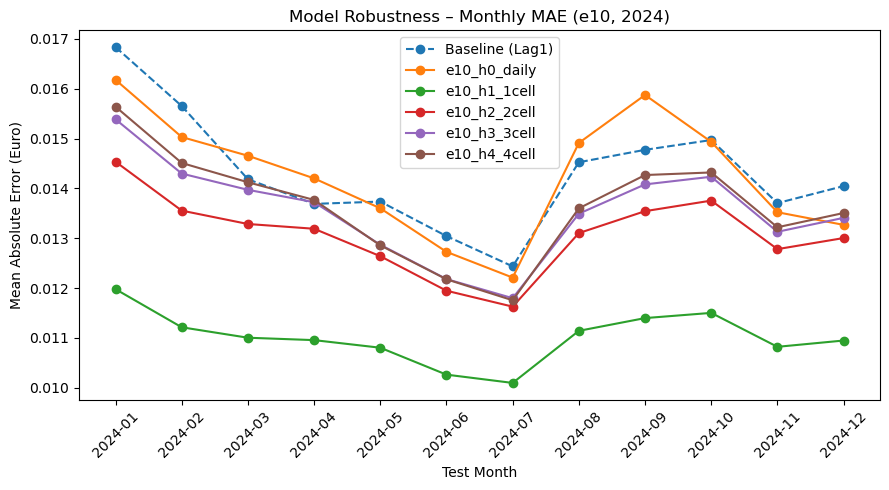

In [ ]:
# Cell X: Walk-forward backtesting for e10 models (2024 only)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

# 1) Reload the e10 feature data

df = pd.read_parquet(FEATURES_PATH)

# Keep only columns we need
cols_needed = {
    "date",
    "price",
    "price_lag_1d",
    "price_lag_2d",
    "price_lag_3d",
    "price_lag_7d",
    "price_lag_1cell",
    "price_lag_2cell",
    "price_lag_3cell",
    "price_lag_4cell",
}
df = df[list(cols_needed)]

df["date"] = pd.to_datetime(df["date"])
df_2024 = df[df["date"].dt.year == 2024].copy()

# Monthly label as 'YYYY-MM' for grouping
df_2024["month"] = df_2024["date"].dt.to_period("M").astype(str)

print(f"2024 subset: {len(df_2024):,} rows")

# 2) Pre-load models once

loaded_models = {}
for cfg in MODEL_CONFIGS:
    model_path = BASE_DIR / cfg["filename"]
    loaded_models[cfg["name"]] = joblib.load(model_path)

# 3) Monthly metrics: baseline + all diesel models

monthly_rows = []

for month, g in df_2024.groupby("month"):
    y_true_full = g["price"]

    # Baseline: yesterday (lag1)
    baseline_pred = g["price_lag_1d"]
    base_mae, base_rmse = get_metrics(y_true_full, baseline_pred)

    row = {
        "Month": month,
        "Test_Rows": len(g),
        "Baseline_MAE": base_mae,
        "Baseline_RMSE": base_rmse,
    }

    # Each horizon-specific model on its own valid subset
    for cfg in MODEL_CONFIGS:
        name = cfg["name"]
        feats = cfg["features"]
        model = loaded_models[name]

        # Drop rows where any required feature is missing for that model
        g_sub = g.dropna(subset=feats)
        if len(g_sub) == 0:
            row[f"{name}_MAE"] = np.nan
            row[f"{name}_RMSE"] = np.nan
            row[f"{name}_Improvement_pct"] = np.nan
            continue

        y = g_sub["price"]
        X = g_sub[feats]
        y_pred = model.predict(X)

        mae_m, rmse_m = get_metrics(y, y_pred)
        row[f"{name}_MAE"] = mae_m
        row[f"{name}_RMSE"] = rmse_m
        row[f"{name}_Improvement_pct"] = (base_mae - mae_m) / base_mae * 100.0

    monthly_rows.append(row)

results_2024 = pd.DataFrame(monthly_rows).sort_values("Month").reset_index(drop=True)

# 4) Table

print("=" * 70)
print("WALK-FORWARD VALIDATION RESULTS – e10 MODELS (2024)")
print("=" * 70)

cols_to_show = [
    "Month",
    "Test_Rows",
    "Baseline_MAE",
]

# add MAE + improvement columns for each model
for cfg in MODEL_CONFIGS:
    name = cfg["name"]
    cols_to_show.extend([f"{name}_MAE", f"{name}_Improvement_pct"])

table = results_2024[cols_to_show].copy()

# formatted text output
print(f"{'Month':<8} {'Rows':>10}  {'BaseMAE':>8}  ", end="")
for cfg in MODEL_CONFIGS:
    name = cfg["name"]
    print(f"{name+'_MAE':>14} {name+'_ΔMAE%':>12}", end="  ")
print()

for _, row in table.iterrows():
    print(
        f"{row['Month']:<8} {int(row['Test_Rows']):>10}  "
        f"{row['Baseline_MAE']:.4f}  ",
        end="",
    )
    for cfg in MODEL_CONFIGS:
        name = cfg["name"]
        mae = row[f"{name}_MAE"]
        imp = row[f"{name}_Improvement_pct"]
        if np.isnan(mae):
            print(f"{'n/a':>14} {'n/a':>12}", end="  ")
        else:
            print(f"{mae:>14.4f} {imp:>12.2f}", end="  ")
    print()

# Average improvement across months 
print("\nAverage improvement vs baseline (2024):")
for cfg in MODEL_CONFIGS:
    name = cfg["name"]
    avg_imp = results_2024[f"{name}_Improvement_pct"].mean()
    print(f"  {name:18s}: {avg_imp:6.2f}%")

# 5) Plot: monthly MAE – baseline + 5 e10 models

plt.figure(figsize=(9, 5))

x = results_2024["Month"]

# Baseline
plt.plot(x, results_2024["Baseline_MAE"], marker="o", linestyle="--", label="Baseline (Lag1)")

for cfg in MODEL_CONFIGS:
    name = cfg["name"]
    plt.plot(
        x,
        results_2024[f"{name}_MAE"],
        marker="o",
        label=name,
    )

plt.title("Model Robustness – Monthly MAE (e10, 2024)")
plt.xlabel("Test Month")
plt.ylabel("Mean Absolute Error (Euro)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()